In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import display
import seaborn as sns
%matplotlib inline

from definitions import DEMOG_FILE, DEMOG_SCHEMA, BEHAVIOR_FILE, BEHAVIOR_SCHEMA, WEIGHTS_FILE, WEIGHTS_SCHEMA, SPARK_DATA_DIR, FOLLOWINGS_SCHEMA, FOLLOWINGS_FILE

pd.set_option('display.float_format', '{:.3f}'.format)

REGISTERED_VOTERS_ONLY = True
EXCLUDE_HIGH_TWEETERS = True

In [2]:
def weighted_histogram(df, var, weight_var="weight", normalize=True):
    df = df[(pd.notnull(df[var])) & (pd.notnull(df[weight_var]))]
    hist = (df.groupby(var)
                    .agg({'id': 'count', weight_var: 'sum'})
                    .rename({'id': 'unweighted', weight_var: 'weighted'}, axis=1)
                    .reset_index())
    if normalize:
        hist['unweighted'] /= df.shape[0]
        hist['weighted'] /= df[weight_var].sum()
    return hist

# https://stackoverflow.com/questions/26102867/python-weighted-median-algorithm-with-pandas   
def weighted_quantile(df, val, weight, quantile):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() * quantile
    df = df_sorted[cumsum >= cutoff]
    return df[val].iloc[0]

def weighted_median(df, val, weight='weight'):
    return weighted_quantile(df, val, weight, 0.5)

In [3]:
demog = pd.read_csv(DEMOG_FILE,
                 header=None,
                 sep='\t', 
                 names=list(DEMOG_SCHEMA.keys()),
                 dtype=DEMOG_SCHEMA,
                )
demog['active'] = demog['last_tweet'] > 1567296000

In [4]:
if REGISTERED_VOTERS_ONLY:
    demog = demog[demog['registration_status'] == 1.]
print(demog.shape)

(1496434, 21)


In [5]:
weights = pd.read_csv(WEIGHTS_FILE,
                      sep=",",
                      names=list(WEIGHTS_SCHEMA.keys()),
                      dtype=WEIGHTS_SCHEMA,
                      quotechar='"',
                      header=0)
demog = demog.merge(weights, how='left', on='id')
demog = demog[pd.notnull(demog['weight'])]
demog.drop(columns=['id', 'zip', 'first_tweet', 'last_tweet', 'state', 'user_created_at']).head()

,num_tweets,age,gender,race,party,cd,county_fips,partisan_score,registration_status,statuses_count,favourites_count,followers_count,friends_count,verified,active,weight
0,19,46.000,Male,Native American,Democrat,1.000,31,90.700,1.000,19.000,0.000,1.000,75.000,False,False,1.445
1,4,27.000,Male,Caucasian,Unaffiliated,4.000,111,46.900,1.000,4.000,0.000,2.000,7.000,False,False,0.499
2,430,45.000,Male,Caucasian,Unaffiliated,1.000,203,5.700,1.000,430.000,1.000,80.000,50.000,False,False,0.509
3,623,25.000,Female,African-American,Unaffiliated,5.000,83,92.800,1.000,628.000,3.000,403.000,927.000,False,False,1.266
4,3129,26.000,Female,Caucasian,Republican,16.000,71,17.800,1.000,5672.000,54.000,134.000,160.000,False,False,0.449


In [6]:
demog.num_tweets.sum()

2170214086

In [7]:
behavior = pd.read_csv(BEHAVIOR_FILE,
                       sep = "\t",
                       names=list(BEHAVIOR_SCHEMA.keys()),
                       dtype=BEHAVIOR_SCHEMA)

behavior = behavior.merge(weights, how='left', on='id')
behavior = behavior[pd.notnull(behavior['weight'])]
behavior.drop(columns=['id']).head()

,n_impeachment_tweets,n_retweets,n_impeachment_retweets,n_replies,n_replies_alt,n_tweets,weight
0,0,37,0,2,4,47,0.436
1,0,0,0,1,3,20,0.599
2,0,647,0,251,249,1279,0.115
3,0,1,0,0,0,1,0.874
4,0,12,0,0,0,12,0.282


In [8]:
(behavior.n_tweets > 3200).sum()

1615

In [9]:
if REGISTERED_VOTERS_ONLY:
    RV_IDS = set(demog.id.unique())
    behavior=behavior[behavior.id.isin(RV_IDS)]

In [10]:
(behavior.n_tweets).sum()

52630684

In [11]:
# TRUNCATE
if EXCLUDE_HIGH_TWEETERS:
    behavior = behavior[behavior.n_tweets<=3200]

In [12]:
(behavior.n_tweets).sum()

46539343

In [13]:
demog.shape[0] - behavior.shape[0]

894526

In [14]:
(demog.shape[0] - behavior[behavior.n_tweets > 0].shape[0])/demog.shape[0]

0.5977721688842734

In [15]:
behavior.shape

(601907, 8)

In [16]:
behavior['percentile'] = behavior.n_tweets.rank(pct=True)
behavior['any_impeachment_tweets'] = (behavior.n_impeachment_tweets>0).astype(int)

In [17]:
weighted_cut_point = weighted_quantile(behavior, "n_tweets", "weight", 0.9)

In [18]:
behavior[behavior.percentile > 0.9].n_tweets.sum() / behavior.n_tweets.sum() 

0.703801512625565

In [19]:
(behavior[behavior.n_tweets > weighted_cut_point].n_tweets * behavior[behavior.n_tweets > weighted_cut_point].weight).sum() / (behavior.n_tweets * behavior.weight).sum() 

0.7279228790989034

In [20]:
merged_df = demog.merge(behavior, how='right', on=['id', 'weight'])
merged_df.n_tweets.fillna(0, inplace=True)

In [21]:
merged_df['percentile'] = merged_df.n_tweets.rank(pct=True)

print(merged_df[merged_df.percentile > 0.9].n_tweets.sum() / merged_df.n_tweets.sum() )
print((merged_df[merged_df.percentile > 0.9].n_tweets * merged_df[merged_df.percentile > 0.9].weight).sum() / (merged_df.n_tweets * merged_df.weight).sum())

0.703801512625565
0.7380122797008051


In [22]:
behavior['rt_percent'] = behavior['n_retweets'] / behavior['n_tweets']

In [23]:
print(np.mean(behavior['rt_percent']))
print(np.average(behavior['rt_percent'], weights=behavior['weight']))

0.34649921208595674
0.3122728441347586


In [24]:
behavior['reply_percent'] = behavior['n_replies'] / behavior['n_tweets']

In [25]:
print(np.mean(behavior['reply_percent']))
print(np.average(behavior['reply_percent'], weights=behavior['weight']))

0.25314373959903785
0.26099663588320204


In [26]:
behavior['reply_percent_alt'] = behavior['n_replies_alt'] / behavior['n_tweets']
print(np.mean(behavior['reply_percent_alt']))
print(np.average(behavior['reply_percent_alt'], weights=behavior['weight']))

0.28756448110920285
0.298493620299747


In [27]:
percentile_cut_points = np.array([weighted_quantile(behavior, "n_tweets", "weight", x) for x in np.linspace(0, 1, 101)])

In [28]:
(percentile_cut_points > 100).argmax()

85

In [29]:
sorted_behavior = behavior.sort_values("n_tweets").reset_index()

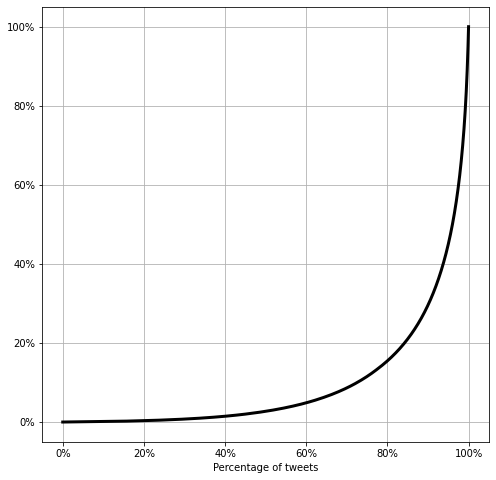

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
(sorted_behavior.n_tweets.cumsum()/sorted_behavior.n_tweets.sum()).plot(ax = ax, color="black", lw=3)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xticks([0] + [sorted_behavior.shape[0]*x for x in [0.2, 0.4, 0.6, 0.8, 1.0]])
ax.set_xticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_xlabel("Percentage of active users")
ax.set_xlabel("Percentage of tweets")
ax.grid()

In [31]:
# https://github.com/oliviaguest/gini
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [32]:
gini(behavior.n_tweets.astype(np.float64).values)

0.8057518991312264

In [33]:
weighted_histogram(merged_df[merged_df.any_impeachment_tweets == 1], "gender")

,gender,unweighted,weighted
0,Female,0.474,0.481
1,Male,0.504,0.510
2,Unknown,0.022,0.009


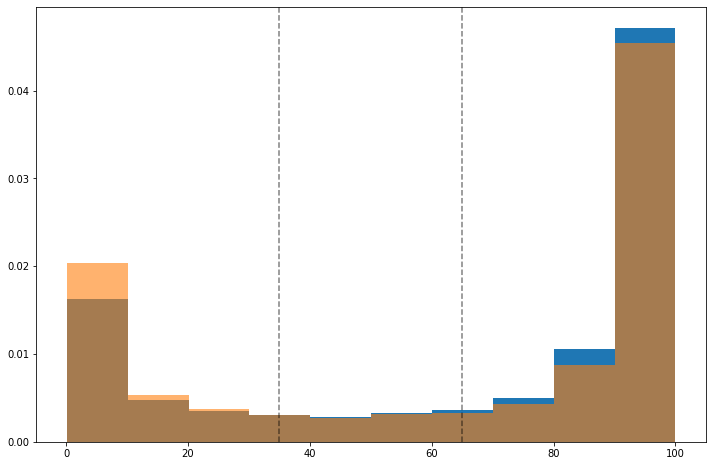

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(merged_df[merged_df.any_impeachment_tweets == 1].partisan_score, density=True)
ax.hist(merged_df[merged_df.any_impeachment_tweets == 1].partisan_score, weights=merged_df[merged_df.any_impeachment_tweets == 1].weight, alpha=0.6, density=True)
ax.axvline(35, color='black', linestyle='--', alpha=0.5)
ax.axvline(65, color='black', linestyle='--', alpha=0.5)

In [35]:
behavior.shape[0]/demog.shape[0]

0.4022278311157265

## Activity and Attrition

Here we will focus on first and last tweet times.

In [36]:
last_tweet_times = (pd.Timestamp("20191101") - pd.to_datetime(demog['last_tweet'], unit='s')) / np.timedelta64(1, "D") // 7

In [37]:
last_tweet_times.describe()

count   1496433.000
mean         68.218
std          88.375
min        -263.000
25%          -1.000
50%          24.000
75%         120.000
max         628.000
Name: last_tweet, dtype: float64

A very skew distribution, as the visualization will show. (Note the negative values; there are a few misbehaving tweets that appear to be from the future. We can disregard these.) 

The modal user has tweeted in the last week; the median user has tweeted within the last half-year; the average user last tweeted over a year ago.

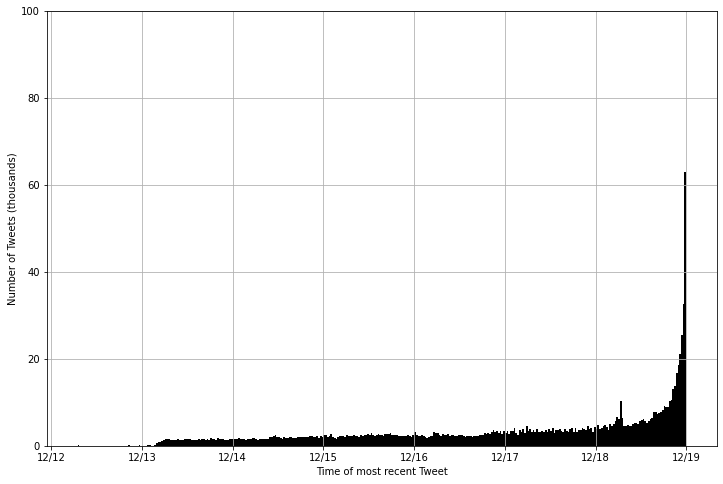

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
last_tweet_times.hist(bins=list(range(0, 350)), ax=ax, color='black', width=1)
ax.invert_xaxis()
ax.set_ylabel("Number of Tweets (thousands)")
ax.set_yticks([0, 20000, 40000, 60000, 80000, 100000])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.set_xlabel("Time of most recent Tweet")
ax.set_xticks([0, 52, 104, 156, 208, 260, 312, 364])
ax.set_xticklabels(["12/19", "12/18", "12/17", "12/16", "12/15", "12/14", "12/13", "12/12"])
fig.savefig("recent_tweets.png", bbox_inches='tight')
fig.savefig("recent_tweets.pdf", bbox_inches='tight')

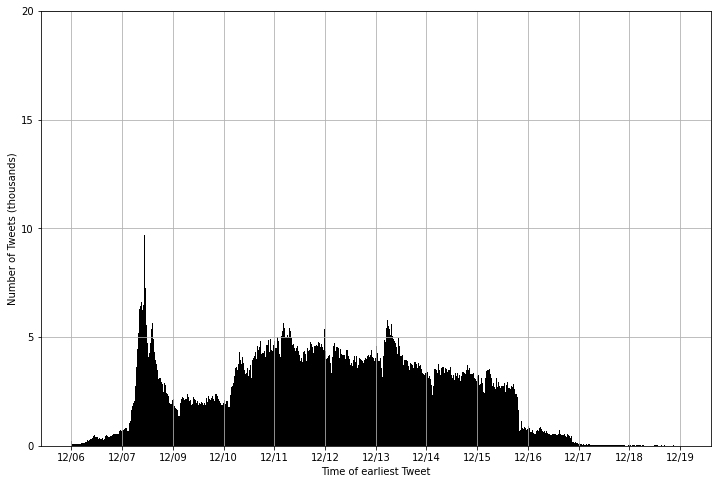

In [39]:
first_tweet_times = (pd.Timestamp("20191101") - pd.to_datetime(demog['first_tweet'], unit='s')) / np.timedelta64(1, "D") // 7
fig, ax = plt.subplots(figsize=(12, 8))
first_tweet_times.hist(bins=list(range(0, 625)), ax=ax, color='black', width=1)
ax.invert_xaxis()
ax.set_ylabel("Number of Tweets (thousands)")
ax.set_yticks([0,5000, 10000, 15000, 20000])
ax.set_yticklabels(["0", "5", "10", "15", "20"])
ax.set_xlabel("Time of earliest Tweet")
ax.set_xticks([0, 52, 104, 156, 208, 260, 312, 364, 416, 468, 520, 572, 624])
ax.set_xticklabels(["12/19", "12/18", "12/17", "12/16", "12/15", "12/14", "12/13", "12/12", "12/11", "12/10", "12/09", "12/07", "12/06"])
fig.savefig("earliest_tweets.png", bbox_inches='tight')
fig.savefig("earliest_tweets.pdf", bbox_inches='tight')

# Twitter Activity (from metadata)

In [40]:
demog['user_created_at'] = pd.to_datetime(demog['user_created_at'], format="%a %b %d %H:%M:%S %z %Y")

In [41]:
demog.loc[:, ["num_tweets", "statuses_count", "favourites_count", "friends_count", "followers_count"]].describe()

,num_tweets,statuses_count,favourites_count,friends_count,followers_count
count,1496433.000,1496433.000,1496433.000,1496433.000,1496433.000
mean,1450.258,2712.863,2721.924,421.102,492.466
std,3057.203,9945.953,10511.063,2077.499,7736.652
min,1.000,0.000,0.000,0.000,0.000
25%,83.000,80.000,17.000,77.000,30.000
50%,440.000,431.000,173.000,192.000,92.000
75%,2026.000,2013.000,1420.000,422.000,273.000
max,128549.000,2988655.000,1036231.000,918007.000,2872613.000


In [42]:
print(weighted_median(demog, "num_tweets", "weight"))
print(weighted_median(demog, "statuses_count", "weight"))
print(weighted_median(demog, "favourites_count", "weight"))
print(weighted_median(demog, "friends_count", "weight"))
print(weighted_median(demog, "followers_count", "weight"))

306
300.0
88.0
159.0
67.0


In [43]:
demog['days_old'] = (pd.Timestamp("20191101", tz="UTC") - demog['user_created_at']) / np.timedelta64(1, "D") // 1

In [44]:
demog['days_old'].describe()

count   1496433.000
mean       2874.674
std         792.234
min        1156.000
25%        2279.000
50%        2924.000
75%        3595.000
max        4972.000
Name: days_old, dtype: float64

In [45]:
weighted_median(demog, 'days_old', 'weight')

2936.0

# Top 10% Tweeters

In [46]:
active_demog = demog[demog.active]

In [47]:
demog['rank_panel_tweets'] = demog['num_tweets'].rank(pct=True)
demog['rank_all_tweets'] = demog['statuses_count'].rank(pct=True)

print(demog[demog['rank_panel_tweets']>0.9]['num_tweets'].sum()/demog['num_tweets'].sum())
print(demog[demog['rank_all_tweets']>0.9]['statuses_count'].sum()/demog['statuses_count'].sum())

0.47412052830994295
0.680740436363035


In [48]:
active_demog.loc[:, 'rank_panel_tweets'] = active_demog.loc[:, 'num_tweets'].rank(pct=True)
active_demog.loc[:, 'rank_all_tweets'] = active_demog.loc[:, 'statuses_count'].rank(pct=True)

/home/smccabe/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/smccabe/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [49]:
print(active_demog[active_demog['rank_panel_tweets']>0.9]['num_tweets'].sum()/active_demog['num_tweets'].sum())
print(active_demog[active_demog['rank_all_tweets']>0.9]['statuses_count'].sum()/active_demog['statuses_count'].sum())

0.4121753207927733
0.5934488215774295


In [50]:
weighted_cut_point = weighted_quantile(demog, 'num_tweets', 'weight', 0.9)

In [51]:
(demog[demog.num_tweets>weighted_cut_point].num_tweets*demog[demog.num_tweets>weighted_cut_point].weight).sum()/(demog.num_tweets * demog.weight).sum()

0.548442464208855

In [52]:
(demog[demog.statuses_count>weighted_cut_point].statuses_count*demog[demog.statuses_count>weighted_cut_point].weight).sum()/(demog.statuses_count * demog.weight).sum()

0.8123130564188435

## Impeachment

In [53]:
KEYWORD_SCHEMA = {
    'text': 'str',
    'id': 'str',
    'tweet_id': 'str', # oops, duplicated the user id instead
    'created_at': 'str'
}

In [54]:
impeachment_tweets = pd.read_csv(f"{SPARK_DATA_DIR}/poq_text/impeachment.tsv", sep="\t", names=list(KEYWORD_SCHEMA.keys()), dtype=KEYWORD_SCHEMA)
# head() not shown because all columns are potentially identifying
# impeachment_tweets.head()

In [55]:
impeachment_tweets = impeachment_tweets[impeachment_tweets.id.isin(behavior.id)]

In [56]:
import re
RT_REGEXP = re.compile("^RT @")
def is_rt(x):
    return True if RT_REGEXP.match(x) else False
(impeachment_tweets['text'].apply(is_rt)).mean()

0.6231159522611172

In [57]:
impeachment_counts = impeachment_tweets.groupby('id').count()['text'].reset_index().rename({"text": "n_impeachment_tweets"}, axis=1)
impeachment_counts.drop(columns=['id']).head()

,n_impeachment_tweets
0,1
1,2
2,157
3,2
4,1


In [58]:
demog = demog.merge(impeachment_counts, how="left", on="id")
demog = demog[demog.id.isin(behavior.id)]

In [59]:
demog.shape

(601907, 26)

In [60]:
demog.n_impeachment_tweets.fillna(0, inplace=True)
demog[['n_impeachment_tweets']].head()

,n_impeachment_tweets
6,1.000
10,0.000
13,2.000
14,0.000
15,0.000


In [61]:
demog['any_impeachment_tweets'] = (demog['n_impeachment_tweets'] > 0).astype(int)
impeachment_df = demog[demog['any_impeachment_tweets'] == 1]
weighted_histogram(demog, 'any_impeachment_tweets')

,any_impeachment_tweets,unweighted,weighted
0,0,0.870,0.840
1,1,0.130,0.160


In [62]:
print(np.median(impeachment_df['n_impeachment_tweets']))
print(weighted_median(impeachment_df, 'n_impeachment_tweets'))

2.0
3.0


In [63]:
print(impeachment_df['n_impeachment_tweets'].describe())
print(np.average(impeachment_df['n_impeachment_tweets'], weights=impeachment_df['weight']))

count   78428.000
mean       14.719
std        45.441
min         1.000
25%         1.000
50%         2.000
75%         8.000
max      1153.000
Name: n_impeachment_tweets, dtype: float64
20.39006837394463


In [64]:
impeachment_tweets['is_rt'] = impeachment_tweets['text'].apply(is_rt)
impeachment_non_rts = impeachment_tweets[~impeachment_tweets['is_rt']]

impeachment_non_rtcounts = impeachment_non_rts.groupby('id').count()['text'].reset_index().rename({"text": "n_impeachment_non_rts"}, axis=1)
demog = demog.merge(impeachment_non_rtcounts, how="left", on="id")

In [65]:
demog['any_impeachment_non_rt'] = (demog['n_impeachment_non_rts'] > 0).astype(int)
impeachment_non_rt_df = demog[demog['any_impeachment_non_rt'] == 1]
weighted_histogram(demog, 'any_impeachment_non_rt')

,any_impeachment_non_rt,unweighted,weighted
0,0,0.919,0.891
1,1,0.081,0.109


In [66]:
print(np.median(impeachment_non_rt_df['n_impeachment_non_rts']))
print(weighted_median(impeachment_non_rt_df, 'n_impeachment_non_rts'))

2.0
2.0


In [67]:
impeachment_tweets.id.nunique()

78428

# Followings

In [68]:
follow_df = pd.read_csv(FOLLOWINGS_FILE, sep='\t', dtype=FOLLOWINGS_SCHEMA)
#follow_df = pd.read_csv('../follow/followings.tsv', sep='\t')

demog = demog.merge(follow_df, how='left', on='id')
follow_df.drop(columns=['id']).head()

,aoc,senatedems,senategop,housedemocrats,housegop,tedcruz
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [69]:
weighted_histogram(demog, 'aoc')

,aoc,unweighted,weighted
0,0,0.840,0.849
1,1,0.160,0.151


In [70]:
weighted_histogram(demog, 'senategop')

,senategop,unweighted,weighted
0,0,0.981,0.973
1,1,0.019,0.027


In [71]:
weighted_histogram(demog, 'tedcruz')

,tedcruz,unweighted,weighted
0,0,0.960,0.948
1,1,0.040,0.052


In [72]:
weighted_histogram(demog, 'senatedems')

,senatedems,unweighted,weighted
0,0,0.969,0.963
1,1,0.031,0.037


In [73]:
weighted_histogram(demog, 'housedemocrats')

,housedemocrats,unweighted,weighted
0,0,0.971,0.965
1,1,0.029,0.035


In [74]:
weighted_histogram(demog, 'housegop')

,housegop,unweighted,weighted
0,0,0.982,0.976
1,1,0.018,0.024


In [75]:
demog.senatedems.sum()

18817

In [76]:
behavior[behavior.n_tweets > 3200]['id'].to_csv("active_ids.txt", index=False)

In [77]:
missing_tweets = pd.read_csv("missing_tweets.tsv", sep=",", header=None, skiprows=1, names=['id', 'missing_tweets'], dtype={'id': 'str'})

In [78]:
missing_tweets['missing_tweets']

0      31106.000
1      26188.000
2      25737.000
3      25381.000
4      25346.000
          ...   
1120     160.000
1121      58.000
1122      10.000
1123       7.000
1124       4.000
Name: missing_tweets, Length: 1125, dtype: float64

In [79]:
mt_behavior = behavior.merge(missing_tweets, "left").fillna(0)

In [80]:
x=mt_behavior.n_tweets + mt_behavior.missing_tweets
gini(x[x>0].values)

0.8057518991312264

In [81]:
(behavior.n_tweets).sum()

46539343

In [82]:
low_activity = demog[demog.statuses_count <= 50]
low_activity = low_activity[low_activity.statuses_count > 0]
low_activity['white'] = (low_activity.race == "Caucasian").astype(int)
low_activity['male'] = (low_activity.gender == "Male").astype(int)

In [83]:
low_activity.drop(columns=['id', 'state', 'county_fips', 'zip', 'first_tweet', 'last_tweet', 'user_created_at'])

,num_tweets,age,gender,race,party,cd,partisan_score,registration_status,statuses_count,favourites_count,...,n_impeachment_non_rts,any_impeachment_non_rt,aoc,senatedems,senategop,housedemocrats,housegop,tedcruz,white,male
18,23,73.000,Female,Caucasian,No Party,4.000,1.400,1.000,23.000,28.000,...,nan,0,0,0,0,0,0,0,1,0
95,33,31.000,Male,Caucasian,Republican,2.000,1.500,1.000,32.000,76.000,...,nan,0,0,0,0,0,0,0,1,1
159,25,66.000,Male,Caucasian,Democrat,4.000,93.500,1.000,25.000,0.000,...,nan,0,0,0,0,0,0,0,1,1
184,22,37.000,Female,Caucasian,Unaffiliated,4.000,58.900,1.000,22.000,28.000,...,nan,0,0,0,0,0,0,0,1,0
215,34,19.000,Female,Hispanic,Unaffiliated,2.000,92.100,1.000,27.000,73.000,...,nan,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601728,72,24.000,Male,Caucasian,Democrat,7.000,97.300,1.000,42.000,4234.000,...,nan,0,0,0,0,0,0,0,1,1
601761,23,60.000,Female,Asian,Democrat,nan,87.200,1.000,23.000,0.000,...,nan,0,0,0,0,0,0,0,0,0
601774,992,35.000,Male,Caucasian,No Party,2.000,71.000,1.000,42.000,14650.000,...,nan,0,1,0,0,0,0,0,1,1
601827,15,52.000,Female,Caucasian,Unaffiliated,7.000,5.500,1.000,15.000,3.000,...,nan,0,0,0,0,0,0,0,1,0


In [84]:
demog['white'] = (demog.race == "Caucasian").astype(int)
demog['male'] = (demog.gender == "Male").astype(int)

In [85]:
PCT_MALE = demog[demog.gender != "Unknown"].male.mean()
PCT_WHITE = demog[demog.race != "Uncoded"].white.mean()
MEAN_AGE = demog[pd.notnull(demog.age)].age.mean()

In [86]:
demog.race.value_counts(dropna=False)

Caucasian           504765
African-American     41002
Hispanic             26077
Uncoded              15093
Asian                11788
Other                 2044
Native American       1138
Name: race, dtype: int64

In [87]:
 low_activity_counts = low_activity.groupby("statuses_count").agg({"id": "count"}).reset_index().rename(columns={"id": "n"})

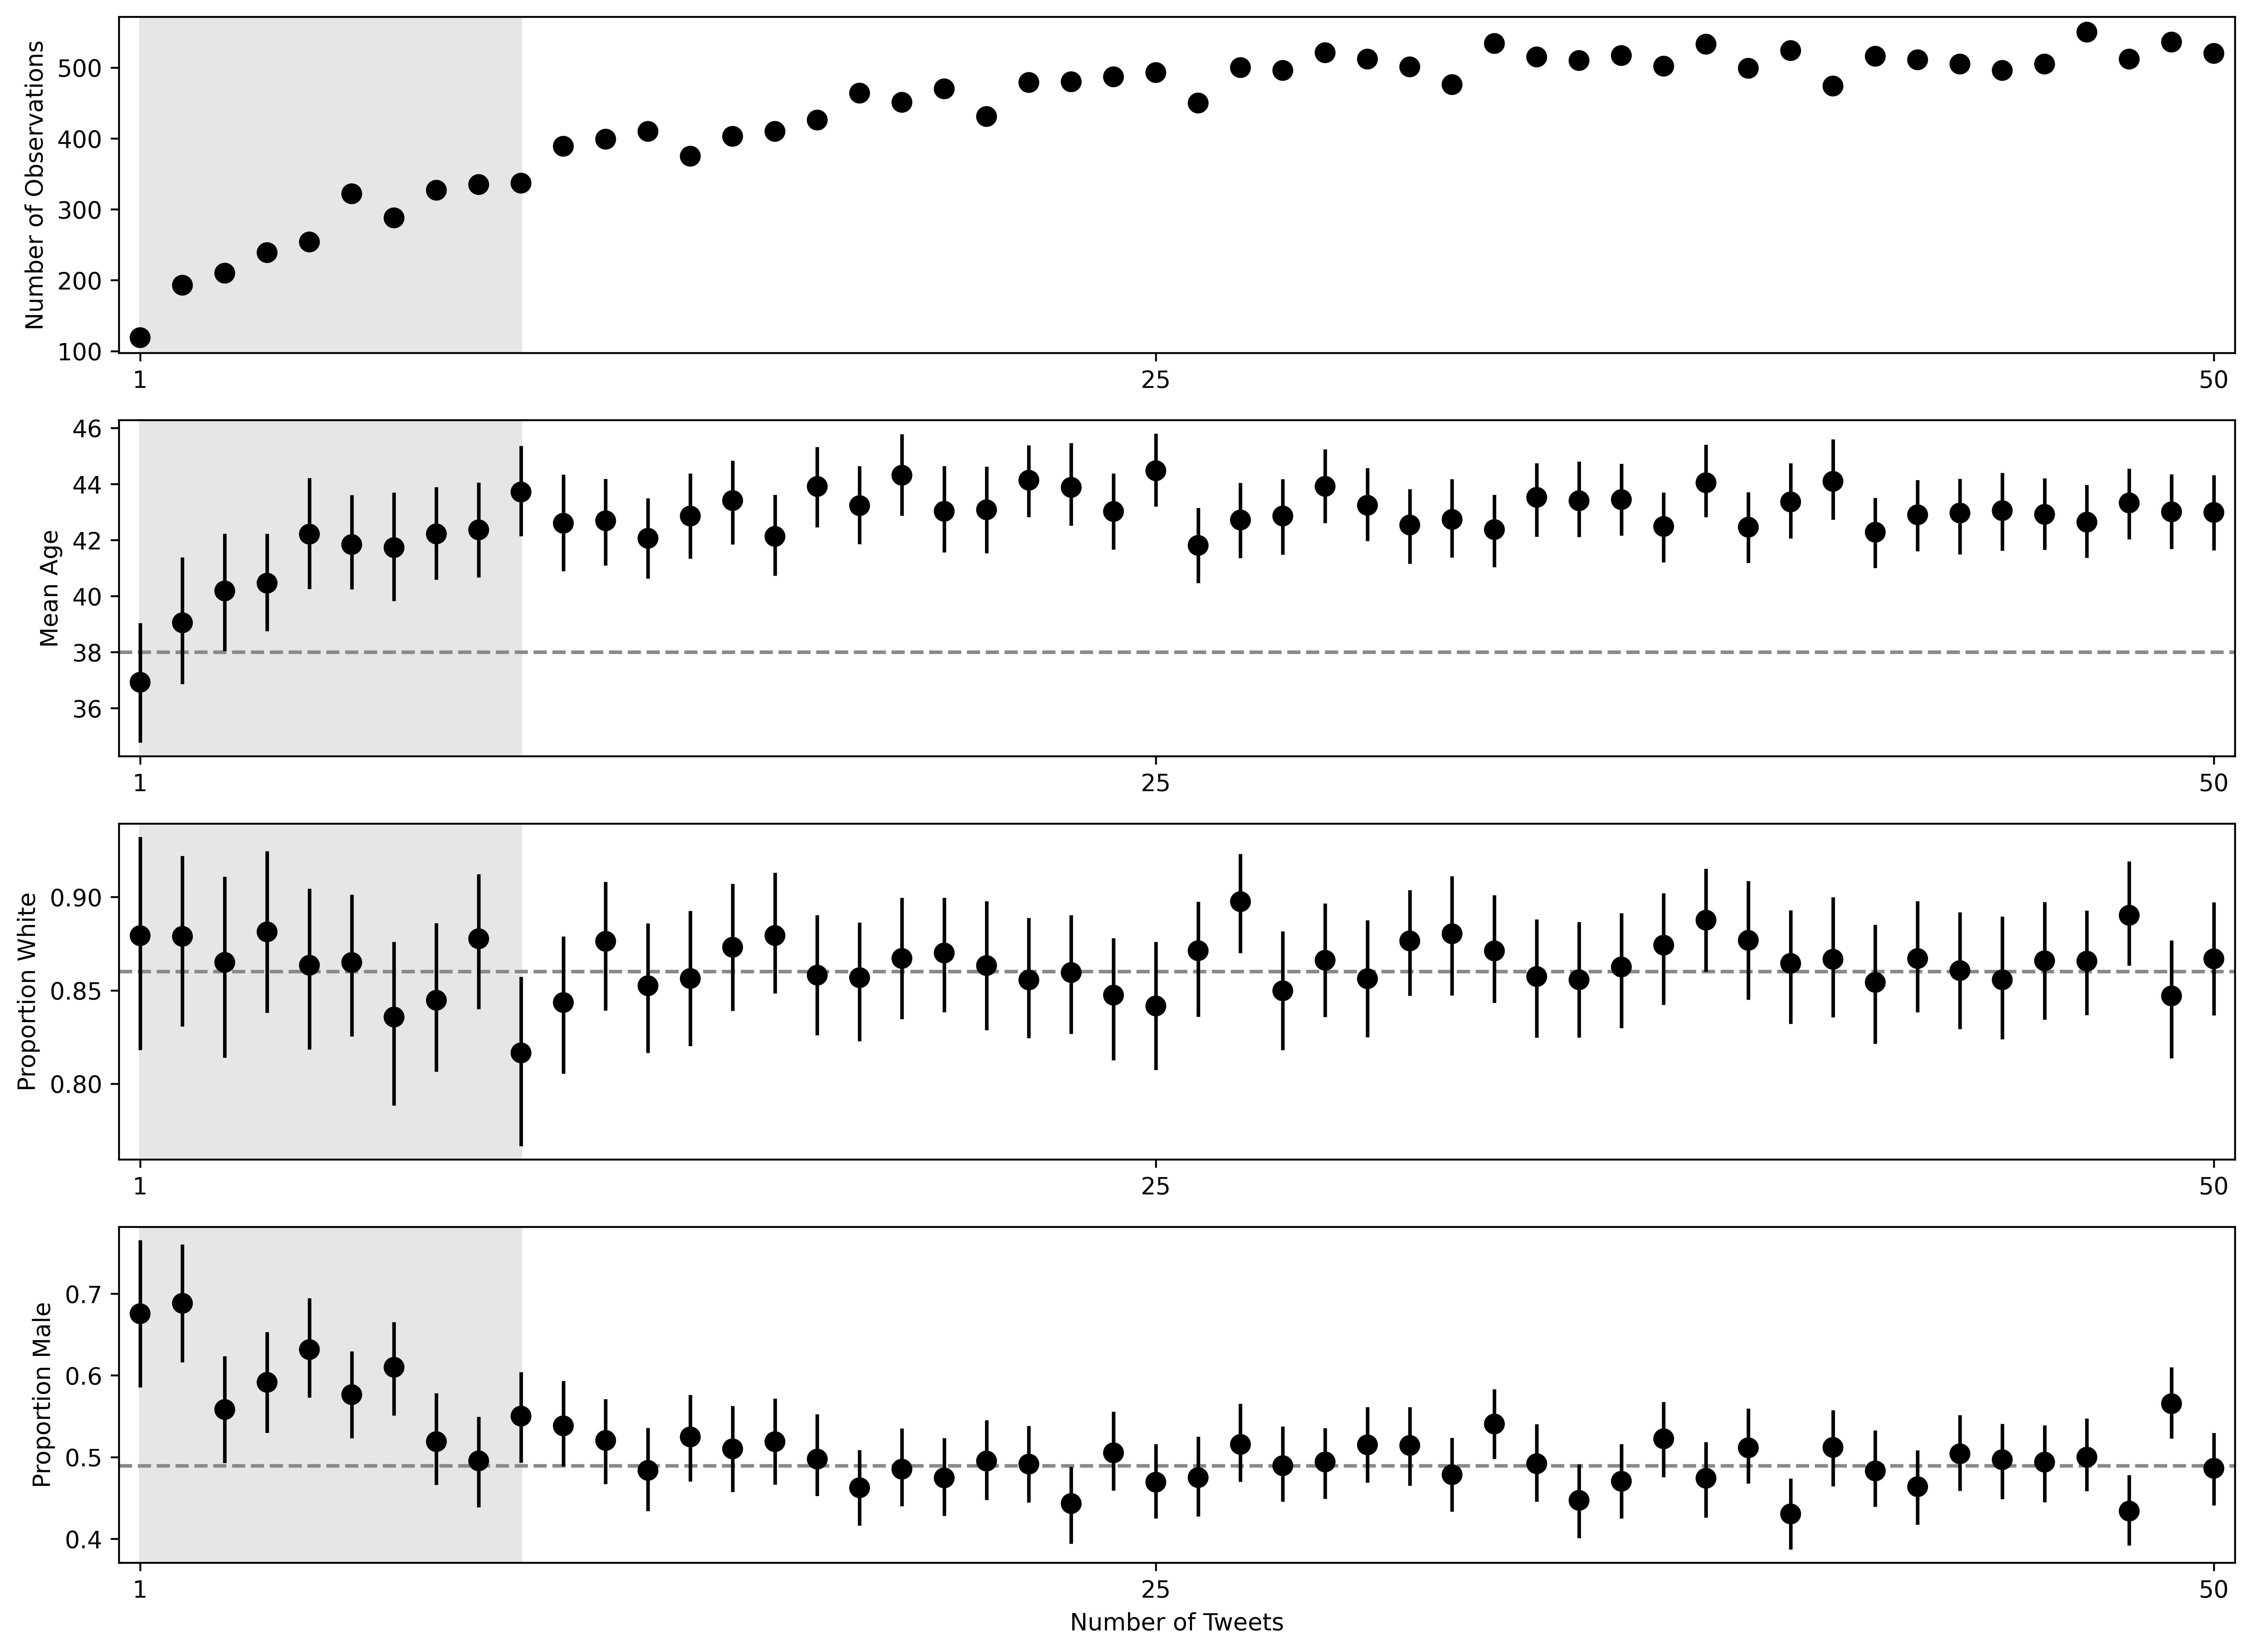

In [88]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(16, 12), dpi=600, facecolor='white')


for ax in (ax0, ax1, ax2, ax3):
#     ax.set_xticks([0, 24, 49])#, 74, 99])
#     ax.set_xticklabels([1, 25, 50])#, 75, 100])
#     ax.set_xlabel("")
    ax.axvspan(0, 9, color='#e5e5e5', zorder=1)



sns.pointplot(x="statuses_count", y="n", data=low_activity_counts, ax=ax0, color="black", errwidth=1.5, linestyles=['', '', ''])
sns.pointplot(x="statuses_count", y="age", data=low_activity[pd.notnull(low_activity.age)], ax=ax1, color="black", errwidth=1.5, linestyles=['', '', ''])
sns.pointplot(x="statuses_count", y="white", data=low_activity[low_activity.race != "Uncoded"], ax=ax2, color="black", errwidth=1.5, linestyles=['', '', ''])
sns.pointplot(x="statuses_count", y="male", data=low_activity[low_activity.gender != "Unknown"], ax=ax3, color="black", errwidth=1.5, linestyles=['', '', ''])

for ax in (ax0, ax1, ax2, ax3):
    ax.set_xticks([0, 24, 49])#, 74, 99])
    ax.set_xticklabels([1, 25, 50])#, 75, 100])
    ax.set_xlabel("")
    plt.setp(ax.lines, zorder=100)
    plt.setp(ax.collections, zorder=100, label="")

ax1.axhline(MEAN_AGE, linestyle="--", color="#88898a", zorder=2)
ax2.axhline(PCT_WHITE, linestyle="--", color="#88898a", zorder=2)
ax3.axhline(PCT_MALE, linestyle="--", color="#88898a", zorder=2)

ax3.set_xlabel("Number of Tweets")
ax0.set_ylabel("Number of Observations")
ax1.set_ylabel("Mean Age")
ax2.set_ylabel("Proportion White")
ax3.set_ylabel("Proportion Male")

fig.savefig("missingness.eps", bbox_inches='tight')